In [16]:
using DrWatson
@quickactivate "TwoCoupledParametrons"

using HarmonicBalance, Symbolics, LinearAlgebra;
using Plots
using Plots.Measures: mm
const HB = HarmonicBalance

HarmonicBalance

In [4]:
############################################################################################
#                           Computing slow-flow equations
############################################################################################

@variables t x(t) y(t) z(t) w(t);
@variables ω0 ω γ λ α η J F;

equations = [d(d(x, t),t) + ω0^2*(1-λ*cos(2*ω*t))*x + γ*d(x,t) + α*x^3 - J*y - J*z - J*w,
             d(d(y ,t),t) + ω0^2*(1-λ*cos(2*ω*t))*y + γ*d(y,t) + α*y^3 - J*x - J*z - J*w,
             d(d(z ,t),t) + ω0^2*(1-λ*cos(2*ω*t))*z + γ*d(z,t) + α*z^3 - J*x - J*y - J*w,
             d(d(w ,t),t) + ω0^2*(1-λ*cos(2*ω*t))*w + γ*d(w,t) + α*w^3 - J*x - J*y - J*z]

system = DifferentialEquation(equations, [x, y, z, w])

add_harmonic!(system, x, ω) # x will rotate at ω
add_harmonic!(system, y, ω) # y will rotate at ω
add_harmonic!(system, z, ω) # z will rotate at ω
add_harmonic!(system, w, ω) # w will rotate at ω

harmonics = get_harmonic_equations(system);

In [5]:
############################################################################################
#                              Compute steady states (2d sweep)
############################################################################################
res = 2
fixed_ωλ = Dict(ω0 => 1.0, γ => 0.005, α => 1.0, η => 0.0, J => 0.005)
varied_ωλ = (ω => range(0.985, 1.015, res), λ => range(1e-6, 0.04, res))

result_ωλ = get_steady_states(harmonics, varied_ωλ, fixed_ωλ, threading=true);

Tracking 6561 paths... 100%|████████████████████████████| Time: 0:00:14
  # paths tracked:                  6561
  # non-singular solutions (real):  625 (1)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         625 (1)


In [6]:
res = 40
fixed_ωλ = Dict(ω0 => 1.0, γ => 0.005, α => 1.0, η => 0.0, J => 0.005)
varied_ωλ = (ω => range(0.985, 1.015, res), λ => range(1e-6, 0.04, res))

result_ωλ = get_steady_states(harmonics, varied_ωλ, fixed_ωλ, threading=true);

Solving for 1600 parameters... 100%|████████████████████| Time: 0:02:46
  # parameters solved:  1600
  # paths tracked:      1000000


Ordering solutions into branches ...  99%|██████████████████████████████████████████████████|  ETA: 0:00:01

In [13]:
############################################################################################
#                              Classify steady states (2d sweep)
############################################################################################
import HarmonicBalance.classify_solutions
include("classification.jl");

sym_basis = get_sym_basis(harmonics, Dict(J => 1))

classify_solutions!(result_ωλ, sol-> is_symmetric(sol; sym_basis=sym_basis), "symmetric")
classify_solutions!(result_ωλ, sol-> is_antisymmetric(sol; sym_basis=sym_basis), "antisymmetric")
classify_solutions!(result_ωλ, sol-> is_mixed(sol; sym_basis=sym_basis), "mixed");
# classify_solutions!(result_ωλ, is_zero, "zero");

Z_All = sum.(HB._get_mask(result_ωλ, ["stable"], []));
Z_sym = sum.(HB._get_mask(result_ωλ, ["stable", "symmetric"], []));
Z_antisym = sum.(HB._get_mask(result_ωλ, ["stable", "antisymmetric"], []));
Z_mixed = sum.(HB._get_mask(result_ωλ, ["stable", "mixed"], []));

In [14]:
16 ∈ unique(Z_All)

false

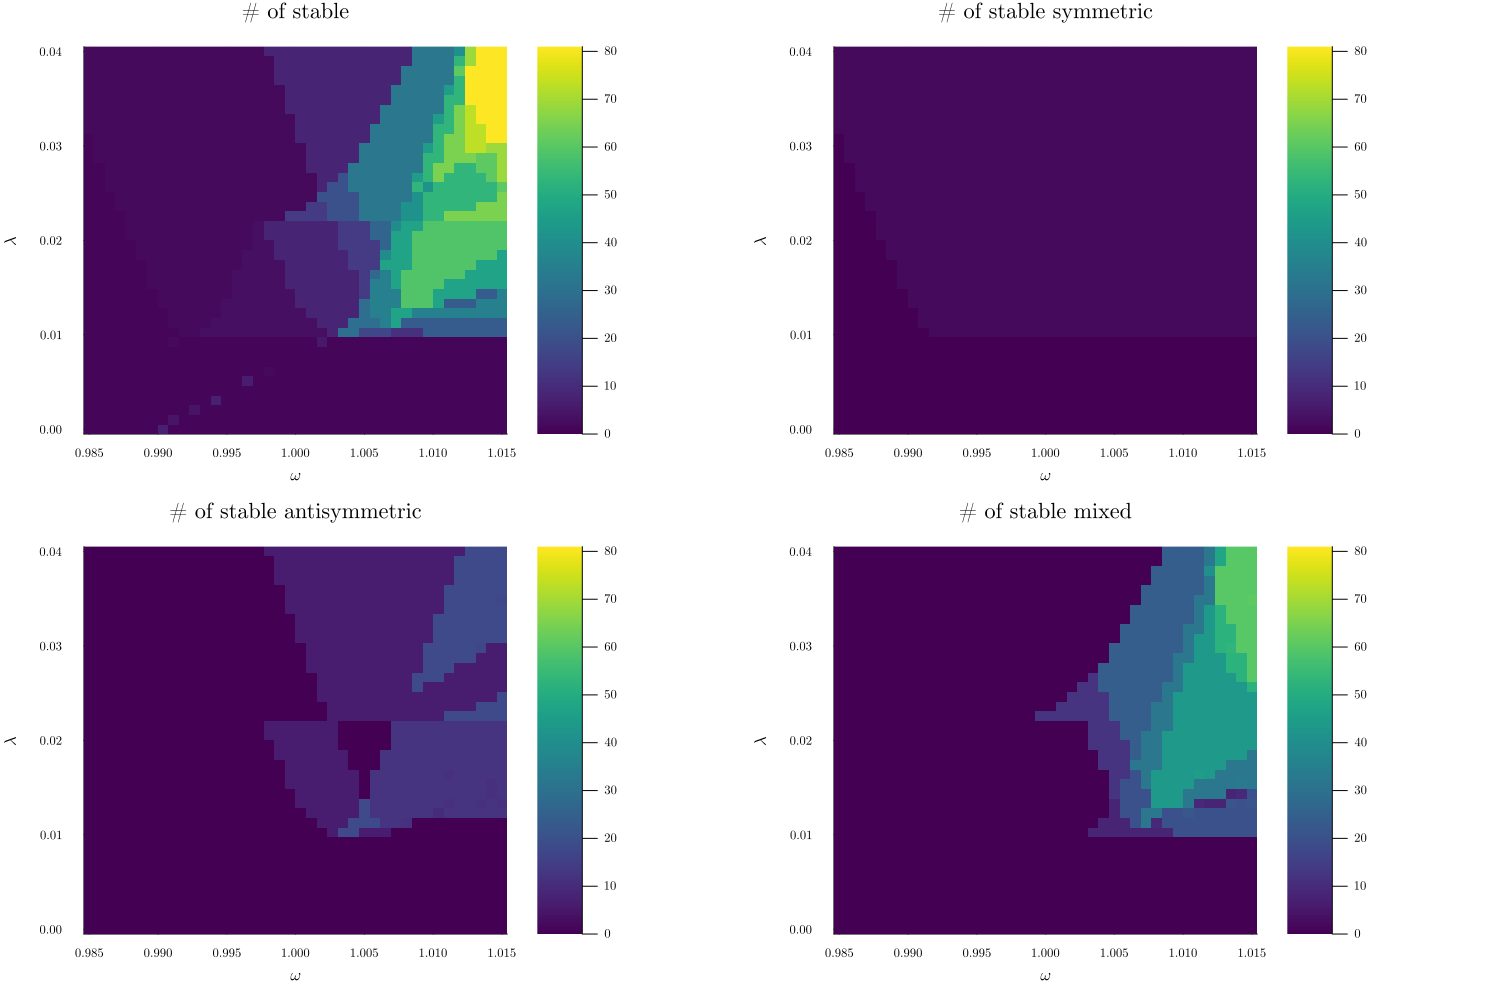

In [17]:
clim = (0,3^4)
color = :viridis
stability_plot = plot_phase_diagram(result_ωλ, class="stable", title="# of stable", clim=clim, color=color)
plot_mixed = plot_phase_diagram(result_ωλ, class=["stable", "mixed"], title="# of stable mixed", clim=clim, color=color)
plot_antisymmetric = plot_phase_diagram(result_ωλ, class=["stable", "antisymmetric"], title="# of stable antisymmetric", clim=clim, color=color)
plot_symmetric = plot_phase_diagram(result_ωλ, class=["stable", "symmetric"], title="# of stable symmetric", clim=clim, color=color)
p = plot(stability_plot, plot_symmetric, plot_antisymmetric, plot_mixed,
     size=(1500, 1000), layout=(2,2), margin=5mm)